In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
boston_df = pd.read_csv('boston_corrected.csv')
boston_gdf  = gpd.GeoDataFrame(boston_df, geometry=gpd.points_from_xy(boston_df.LAT, boston_df.LON))

hospital_df = pd.read_csv('massachusetts-hospitals.csv')
hospital_gdf  = gpd.GeoDataFrame(hospital_df, geometry=gpd.points_from_xy(hospital_df.SHAPE_Y, hospital_df.SHAPE_X))

school_df = pd.read_csv('massachusetts-schools-pre-k-through-high-school.csv')
school_gdf  = gpd.GeoDataFrame(school_df, geometry=gpd.points_from_xy(school_df.SHAPE_Y, school_df.SHAPE_X))

boston_gdf.set_crs(epsg=27700, inplace=True)
hospital_gdf.set_crs(epsg=27700, inplace=True)
school_gdf.set_crs(epsg=27700, inplace=True)

print(boston_gdf.crs.axis_info[0].unit_name)

metre


## Checking and cleaning the data

This data frame contains the following columns:

* TOWN a factor with levels given by town names
    * Should all be strings
    * All have capital letter at the beginning of each word

* TOWNNO a numeric vector corresponding to TOWN
    * Should be int
    * Should be same number as number of unique town names

* TRACT a numeric vector of tract ID numbers
    * Should be int
    * Should be >= 0

* LON a numeric vector of tract point longitudes in decimal degrees
    * Should be float
    * Should be between -180 and 180

* LAT a numeric vector of tract point latitudes in decimal degrees
    * Should be float
    * Should be between -90 and 90

* MEDV a numeric vector of median values of owner-occupied housing in USD 1000
    * Should be float

* CMEDV a numeric vector of corrected median values of owner-occupied housing in USD 1000
    * Should be float

* CRIM a numeric vector of per capita crime
    * Should be float

* ZN a numeric vector of proportions of residential land zoned for lots over 25000 sq. ft per town (constant for all Boston tracts)
    * Should be float

* INDUS a numeric vector of proportions of non-retail business acres per town (constant for all Boston tracts)
    * Should be float

* CHAS a factor with levels 1 if tract borders Charles River; 0 otherwise
    * Should be int

* NOX a numeric vector of nitric oxides concentration (parts per 10 million) per town
    * Should be float

* RM a numeric vector of average numbers of rooms per dwelling
    * Should be float

* AGE a numeric vector of proportions of owner-occupied units built prior to 1940
    * Should be float

* DIS a numeric vector of weighted distances to five Boston employment centres
    * Should be float

* RAD a numeric vector of an index of accessibility to radial highways per town (constant for all Boston tracts)
    * Should be float

* TAX a numeric vector full-value property-tax rate per USD 10,000 per town (constant for all Boston tracts)
    * Should be float

* PTRATIO a numeric vector of pupil-teacher ratios per town (constant for all Boston tracts)
    * Should be float

* B a numeric vector of 1000*(Bk - 0.63)^2 where Bk is the proportion of blacks
    * Should be float

* LSTAT a numeric vector of percentage values of lower status population
    * Should be float

Adapted from: https://nowosad.github.io/spData/reference/boston.html

### Checking that there are no null values and that dtypes are as expected

In [3]:
boston_gdf.head()

,TOWN,TOWNNO,TRACT,LON,LAT,MEDV,CMEDV,CRIM,ZN,INDUS,...,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,geometry
0,Nahant,0,2011,-70.955,42.2550,24.0,24.0,0.00632,18.0,2.31,...,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,POINT (42.25500 -70.95500)
1,Swampscott,1,2021,-70.950,42.2875,21.6,21.6,0.02731,0.0,7.07,...,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,POINT (42.28750 -70.95000)
2,Swampscott,1,2022,-70.936,42.2830,34.7,34.7,0.02729,0.0,7.07,...,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,POINT (42.28300 -70.93600)
3,Marblehead,2,2031,-70.928,42.2930,33.4,33.4,0.03237,0.0,2.18,...,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,POINT (42.29300 -70.92800)
4,Marblehead,2,2032,-70.922,42.2980,36.2,36.2,0.06905,0.0,2.18,...,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,POINT (42.29800 -70.92200)


In [4]:
hospital_gdf.head()

,WKT,TOWN,NAME,STATE,ZIPCODE,ADDRESS,SHORTNAME,SHAPE_X,SHAPE_Y,geometry
0,POINT (-71.3418010264452 42.6472178773122),Lowell,Lowell General Hospital,MA,1854,295 Varnum Avenue,Lowell General Hospital,-71.341801,42.647218,POINT (42.64722 -71.34180)
1,POINT (-71.061448023266 42.4603867279576),Melrose,Hallmark Health System - Melrose-Wakefield Hos...,MA,2176,585 Lebanon Street,Melrose-Wakefield Hospital,-71.061448,42.460387,POINT (42.46039 -71.06145)
2,POINT (-71.528163447604 42.1333878673145),Milford,Milford Regional Medical Center,MA,1757,14 Prospect Street,Milford Regional Medical Center,-71.528163,42.133388,POINT (42.13339 -71.52816)
3,POINT (-71.7912737597095 42.2493973682464),Worcester,Saint Vincent Hospital,MA,1608,123 Summer Street,St. Vincent Hospital,-71.791274,42.249397,POINT (42.24940 -71.79127)
4,POINT (-71.1052811425066 42.3398506547821),Boston,Beth Israel Deaconess Medical Center - East Ca...,MA,2215,330 Brookline Avenue,Beth Israel Deaconess Med Ctr East,-71.105281,42.339851,POINT (42.33985 -71.10528)


In [5]:
school_gdf.head()

,WKT,Description_2,City_Town_Geographic,Master_Address_ID,Name,Fax_No,City_Town_Mailing,Phone_No,State,ESE_Code,Address,Description,Principal,Type,Grades_Offered,ZIP_Code,SHAPE_X,SHAPE_Y,geometry
0,POINT (-70.9318491057449 41.6545680269549),NaN,NEW BEDFORD,4065991,Hayden/McFadden School,508-994-0163,New Bedford,508-997-4511,MA,2010078,361 Cedar Grove,Public,Tammy Morgan,PUB,"PK,K,01,02,03,04,05",2746,-70.931849,41.654568,POINT (41.65457 -70.93185)
1,POINT (-72.6451528932961 42.0734436731309),NaN,AGAWAM,2270173,Agawam High School,413-821-0536,Agawam,413-821-0521,MA,50505,760 Cooper Street,Public,Thomas Schnepp,PUB,"09,10,11,12",1001,-72.645153,42.073444,POINT (42.07344 -72.64515)
2,POINT (-71.2221815242066 42.0253054269432),NaN,MANSFIELD,2554008,Roland Green School,508-261-7415,Mansfield,508-261-1561,MA,1670003,29 Dean Street,Public,Joanne Jordan,PUB,PK,2048,-71.222182,42.025305,POINT (42.02531 -71.22218)
3,POINT (-71.0208840975658 42.4197977682776),NaN,REVERE,3537730,A.C. Whelan Elementary School,781-333-2074,Revere,781-388-7510,MA,2480003,107 Newhall Street,Public,Jamie Flynn,PUB,"K,01,02,03,04,05",2151,-71.020884,42.419798,POINT (42.41980 -71.02088)
4,POINT (-71.0366938141637 42.3939387028766),NaN,CHELSEA,3688851,Joseph A Browne School,617-889-8459,Chelsea,617-466-5235,MA,570055,180 Walnut Street,Public,Julie Shea,PUB,"05,06,07,08",2150,-71.036694,42.393939,POINT (42.39394 -71.03669)


In [6]:
school_gdf.drop('Description_2', axis=1, inplace=True)
school_gdf.head()

,WKT,City_Town_Geographic,Master_Address_ID,Name,Fax_No,City_Town_Mailing,Phone_No,State,ESE_Code,Address,Description,Principal,Type,Grades_Offered,ZIP_Code,SHAPE_X,SHAPE_Y,geometry
0,POINT (-70.9318491057449 41.6545680269549),NEW BEDFORD,4065991,Hayden/McFadden School,508-994-0163,New Bedford,508-997-4511,MA,2010078,361 Cedar Grove,Public,Tammy Morgan,PUB,"PK,K,01,02,03,04,05",2746,-70.931849,41.654568,POINT (41.65457 -70.93185)
1,POINT (-72.6451528932961 42.0734436731309),AGAWAM,2270173,Agawam High School,413-821-0536,Agawam,413-821-0521,MA,50505,760 Cooper Street,Public,Thomas Schnepp,PUB,"09,10,11,12",1001,-72.645153,42.073444,POINT (42.07344 -72.64515)
2,POINT (-71.2221815242066 42.0253054269432),MANSFIELD,2554008,Roland Green School,508-261-7415,Mansfield,508-261-1561,MA,1670003,29 Dean Street,Public,Joanne Jordan,PUB,PK,2048,-71.222182,42.025305,POINT (42.02531 -71.22218)
3,POINT (-71.0208840975658 42.4197977682776),REVERE,3537730,A.C. Whelan Elementary School,781-333-2074,Revere,781-388-7510,MA,2480003,107 Newhall Street,Public,Jamie Flynn,PUB,"K,01,02,03,04,05",2151,-71.020884,42.419798,POINT (42.41980 -71.02088)
4,POINT (-71.0366938141637 42.3939387028766),CHELSEA,3688851,Joseph A Browne School,617-889-8459,Chelsea,617-466-5235,MA,570055,180 Walnut Street,Public,Julie Shea,PUB,"05,06,07,08",2150,-71.036694,42.393939,POINT (42.39394 -71.03669)


In [7]:
boston_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   TOWN      506 non-null    object  
 1   TOWNNO    506 non-null    int64   
 2   TRACT     506 non-null    int64   
 3   LON       506 non-null    float64 
 4   LAT       506 non-null    float64 
 5   MEDV      506 non-null    float64 
 6   CMEDV     506 non-null    float64 
 7   CRIM      506 non-null    float64 
 8   ZN        506 non-null    float64 
 9   INDUS     506 non-null    float64 
 10  CHAS      506 non-null    int64   
 11  NOX       506 non-null    float64 
 12  RM        506 non-null    float64 
 13  AGE       506 non-null    float64 
 14  DIS       506 non-null    float64 
 15  RAD       506 non-null    int64   
 16  TAX       506 non-null    int64   
 17  PTRATIO   506 non-null    float64 
 18  B         506 non-null    float64 
 19  LSTAT     506 non-null    float64 
 20  ge

In [8]:
hospital_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   WKT        82 non-null     object  
 1   TOWN       82 non-null     object  
 2   NAME       82 non-null     object  
 3   STATE      82 non-null     object  
 4   ZIPCODE    82 non-null     int64   
 5   ADDRESS    82 non-null     object  
 6   SHORTNAME  82 non-null     object  
 7   SHAPE_X    82 non-null     float64 
 8   SHAPE_Y    82 non-null     float64 
 9   geometry   82 non-null     geometry
dtypes: float64(2), geometry(1), int64(1), object(6)
memory usage: 6.5+ KB


In [9]:
school_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1773 entries, 0 to 1772
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   WKT                   1773 non-null   object  
 1   City_Town_Geographic  1773 non-null   object  
 2   Master_Address_ID     1756 non-null   object  
 3   Name                  1773 non-null   object  
 4   Fax_No                1773 non-null   object  
 5   City_Town_Mailing     1773 non-null   object  
 6   Phone_No              1773 non-null   object  
 7   State                 1773 non-null   object  
 8   ESE_Code              1773 non-null   int64   
 9   Address               1773 non-null   object  
 10  Description           1773 non-null   object  
 11  Principal             1773 non-null   object  
 12  Type                  1773 non-null   object  
 13  Grades_Offered        1772 non-null   object  
 14  ZIP_Code              1773 non-null   int64   
 

In [10]:
sorted(boston_gdf.TOWN.unique())

['Arlington',
 'Ashland',
 'Bedford',
 'Belmont',
 'Beverly',
 'Boston Allston-Brighton',
 'Boston Back Bay',
 'Boston Beacon Hill',
 'Boston Charlestown',
 'Boston Dorchester',
 'Boston Downtown',
 'Boston East Boston',
 'Boston Forest Hills',
 'Boston Hyde Park',
 'Boston Mattapan',
 'Boston North End',
 'Boston Roxbury',
 'Boston Savin Hill',
 'Boston South Boston',
 'Boston West Roxbury',
 'Braintree',
 'Brookline',
 'Burlington',
 'Cambridge',
 'Canton',
 'Chelsea',
 'Cohasset',
 'Concord',
 'Danvers',
 'Dedham',
 'Dover',
 'Duxbury',
 'Everett',
 'Framingham',
 'Hamilton',
 'Hanover',
 'Hingham',
 'Holbrook',
 'Hull',
 'Lexington',
 'Lincoln',
 'Lynn',
 'Lynnfield',
 'Malden',
 'Manchester',
 'Marblehead',
 'Marshfield',
 'Medfield',
 'Medford',
 'Melrose',
 'Middleton',
 'Millis',
 'Milton',
 'Nahant',
 'Natick',
 'Needham',
 'Newton',
 'Norfolk',
 'North Reading',
 'Norwell',
 'Norwood',
 'Peabody',
 'Pembroke',
 'Quincy',
 'Randolph',
 'Reading',
 'Revere',
 'Rockland',
 'Sale

### Check that the characteristics of each column are as expected as defined above

In [11]:
assert len(boston_gdf.TOWN.unique()) == len(boston_gdf.TOWNNO.unique()), 'Number of unique town names must be equal to number of unique town numbers'
assert all(boston_gdf.TRACT) >= 0, 'ID numbers must be greater than or equal to zero'
assert -180 <= all(boston_gdf.LON) <= 180, 'Longitude must be between -180 and 180'
assert -90 <= all(boston_gdf.LAT) <= 90, 'Latitude must be between -90 and 90'

### Dropping the MEDV column as CMEDV will be used as our target variable and we do not want data leakage

In [12]:
boston_gdf.drop('MEDV', axis=1, inplace=True)

### Dropping TOWN because it repeats information in TOWNNO

In [13]:
boston_gdf.drop('TOWN', axis=1, inplace=True)

## Feature engineering

In [30]:
boston_gdf['dist_nearest_hospital'] = [np.inf for _ in range(len(boston_gdf))]
for idx, hospital in hospital_gdf.iterrows():
    boston_gdf['dist_nearest_hospital'] = [min(a,b) for a,b in zip(boston_gdf['dist_nearest_hospital'],
                                              boston_gdf.geometry.distance(hospital.geometry))]
    
boston_gdf['dist_nearest_school'] = [np.inf for _ in range(len(boston_gdf))]
for idx, school in school_gdf.iterrows():
    boston_gdf['dist_nearest_school'] = [min(a,b) for a,b in zip(boston_gdf['dist_nearest_school'],
                                              boston_gdf.geometry.distance(school.geometry))]

### Seperate explanatory variables from target and split into train and test set (80:20), will be using cross-validation on training set

In [31]:
X = boston_gdf.copy()
y = X.pop('CMEDV')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2021)

### Calculate a mutual information score to understand how knowledge of one quantity reduces uncertainty about the target variable

* 0 means that the quantities are independent
* The higher the score the better
* Scores > 2 are uncommon as mutual information score increases slowly as it is a logarithmic quantity

In [32]:
mi_scores = mutual_info_regression(X.loc[:, X.columns != 'geometry'], y, random_state=2021)
mi_scores_series = pd.Series(mi_scores, name="MI Scores", index=X.loc[:, X.columns != 'geometry'].columns).sort_values(ascending=False)

In [33]:
mi_scores_series

LSTAT                    0.670897
TOWNNO                   0.554340
RM                       0.547838
TRACT                    0.504184
NOX                      0.476729
INDUS                    0.474748
PTRATIO                  0.449761
CRIM                     0.354496
TAX                      0.348987
AGE                      0.319743
LON                      0.312541
DIS                      0.307995
LAT                      0.271908
RAD                      0.215365
ZN                       0.189486
B                        0.173185
dist_nearest_school      0.082683
dist_nearest_hospital    0.045403
CHAS                     0.031144
Name: MI Scores, dtype: float64

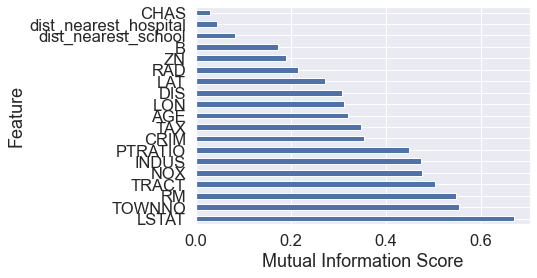

In [34]:
mi_scores_series.plot.barh()
plt.xlabel('Mutual Information Score')
plt.ylabel('Feature')
plt.show()

### Correlation coefficients

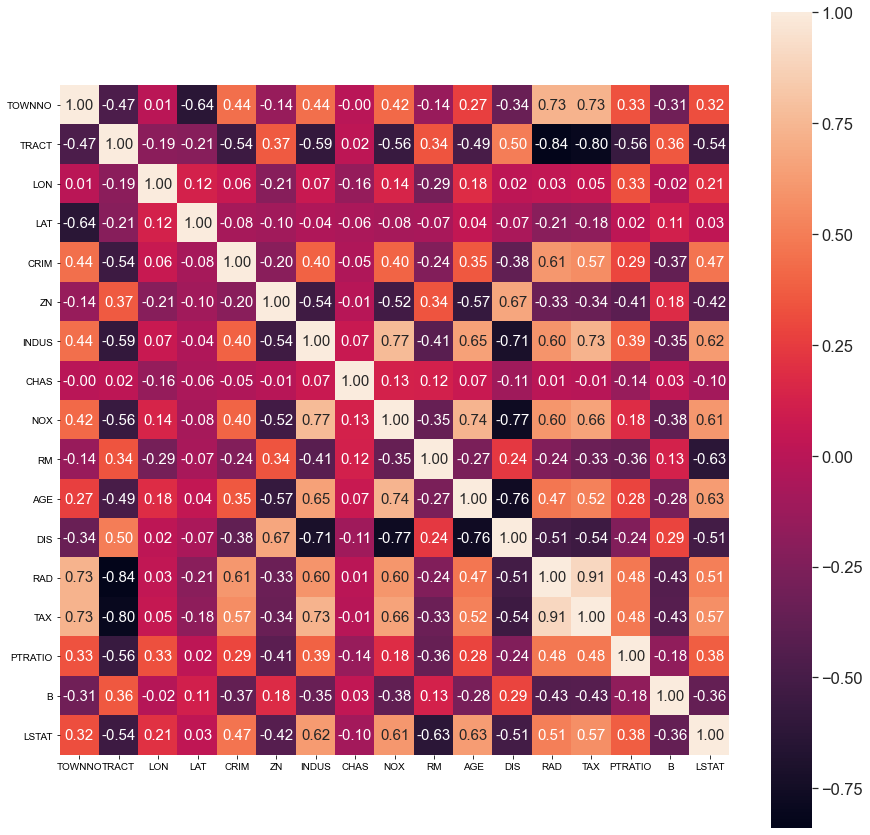

In [24]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(15,15))
cm = np.corrcoef(X_train.loc[:, X.columns != 'geometry'].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm,
                cbar=True,
                annot=True,
                square=True,
                fmt='.2f',
                annot_kws={'size': 15},
                yticklabels=X_train.loc[:, X.columns != 'geometry'].columns,
                xticklabels=X_train.loc[:, X.columns != 'geometry'].columns,
                ax=ax)

### Normalizing data using StandardScaler()

In [36]:
x_scaler = StandardScaler()
X_train_sc = x_scaler.fit_transform(X_train.loc[:, X.columns != 'geometry'])
X_test_sc = x_scaler.transform(X_test.loc[:, X.columns != 'geometry'])

### Principle Component Analysis (PCA)

In [37]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train_sc)

component_names = [f"PC{i+1}" for i in range(X_train_pca.shape[1])]
X_train_pca_df = pd.DataFrame(X_train_pca, columns=component_names)

X_train_pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19
0,-0.484022,-1.558187,1.725825,-0.593357,0.113654,0.973122,0.984515,0.231830,0.293648,-0.604799,0.796487,0.357769,0.125054,0.325840,-0.090362,-0.503645,0.099104,-0.344995,0.297285
1,0.628974,-0.415514,-0.589508,-1.530508,-0.362092,0.716007,-0.072696,-0.202401,0.085431,-0.563808,-1.097939,-0.192813,-0.901199,-0.249997,-0.146721,0.736122,0.914931,0.170299,0.088751
2,-4.306623,3.286328,-0.833528,0.251948,0.255789,-1.264812,-0.718085,-0.580490,-0.440099,-0.787950,0.707203,0.463347,0.456176,0.213964,-0.273224,0.369274,-0.084011,-0.304136,0.536535
3,6.181277,0.877739,1.278416,0.130025,0.824486,-3.195960,-1.046430,1.009043,2.432568,0.188249,0.488519,-0.039493,-0.049939,-0.104429,-0.034549,0.294035,0.039800,0.183621,0.000187
4,0.843770,-2.642605,-0.238749,-0.493592,-1.047114,-0.872447,-0.124487,0.130541,-0.206764,-0.056097,0.734953,1.236906,0.880908,-0.608394,0.042963,0.939787,0.085340,-0.686928,-0.460465


In [40]:
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X_train.loc[:, X.columns != 'geometry'].columns,  # and the rows are the original features
)
loadings = pd.concat([loadings, pd.DataFrame(X_train.loc[:, X.columns != 'geometry'].columns, columns=['col_names'], index=X_train.loc[:, X.columns != 'geometry'].columns)], axis=1)

In [41]:
loadings.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,col_names
TOWNNO,0.230561,0.440892,-0.135811,-0.038873,-0.196025,0.089570,-0.043393,-0.110406,-0.008655,0.005515,-0.205296,-0.009779,-0.265178,-0.144082,0.134153,0.402293,0.474348,0.307931,-0.197201,TOWNNO
TRACT,-0.302296,-0.046784,-0.176041,-0.004498,-0.379483,-0.211212,0.077911,0.080409,0.145194,0.098139,0.063054,0.152804,0.179763,0.017434,0.031268,-0.093453,-0.282959,0.556534,-0.429070,TRACT
LON,0.070382,-0.099591,0.533350,-0.048600,-0.360010,0.152244,0.248481,-0.052064,0.233746,-0.366609,-0.469626,0.088220,-0.043248,-0.147610,0.053431,-0.039250,-0.162735,-0.087588,-0.038534,LON
LAT,-0.030263,-0.468175,0.209773,-0.055310,0.579954,0.087876,-0.002799,-0.016766,-0.073522,-0.222628,-0.070764,-0.101983,0.060895,-0.032187,0.102166,0.139652,0.185614,0.406039,-0.289987,LAT
CRIM,0.233047,0.155282,0.044713,0.029473,0.279439,-0.208031,-0.077290,-0.128641,0.823000,0.144416,-0.028620,0.032261,0.243806,0.087892,0.023469,-0.037725,0.066697,0.017087,0.029974,CRIM


<BarContainer object of 19 artists>

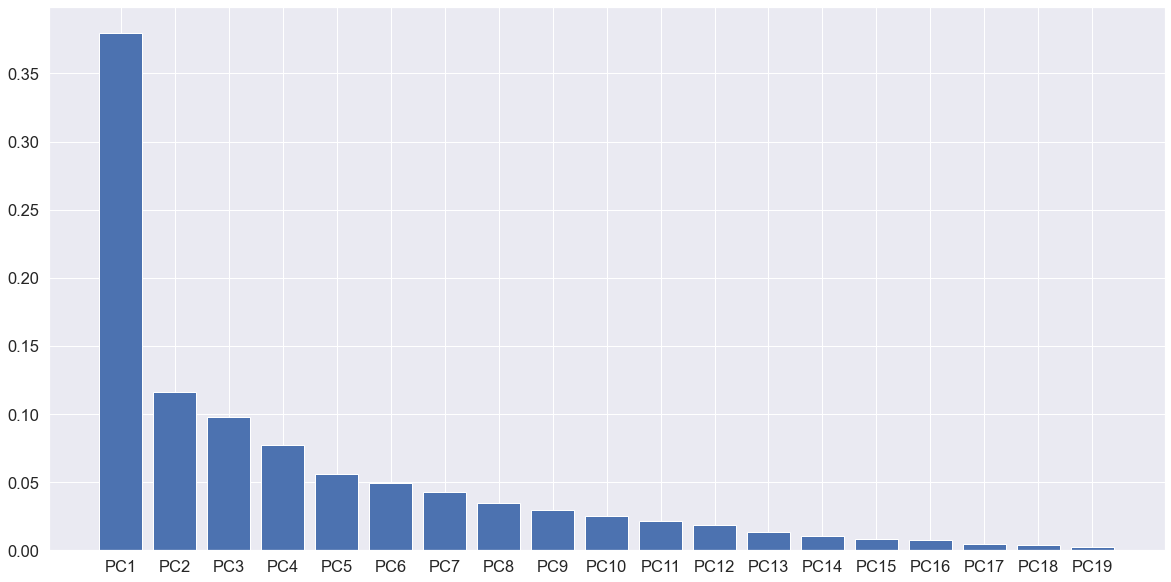

In [45]:
plt.figure(figsize=(20,10))
plt.bar(component_names, pca.explained_variance_ratio_)

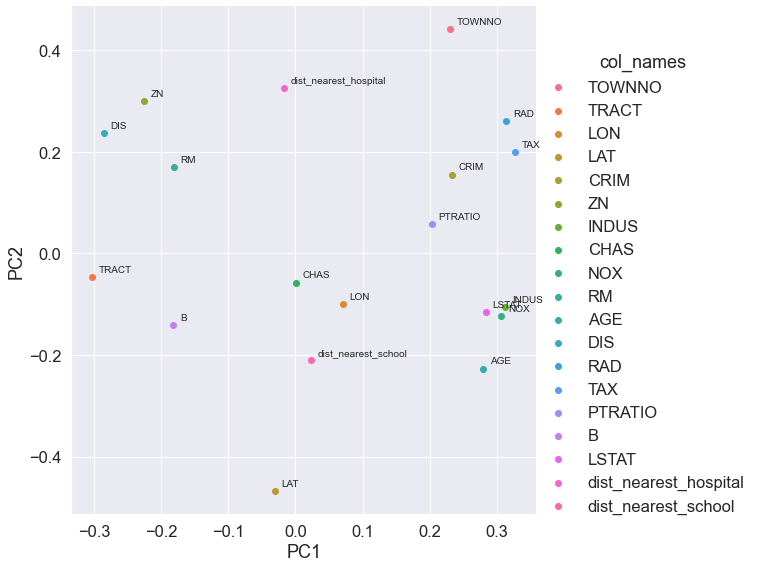

In [47]:
%matplotlib inline

fg = sns.FacetGrid(data=loadings, hue='col_names', hue_order=X_train.loc[:, X.columns != 'geometry'].columns, height=8)
fg.map(plt.scatter, 'PC1', 'PC2').add_legend(ncol=1)
for x, y, label in zip(loadings.PC1, loadings.PC2, loadings.col_names):
    plt.text(x=x+0.01, y=y+0.01, s=label)

### Benchmark model: Linear Regression

In [48]:
def mean_absolute_percentage_error(true, predicted):
    return np.mean(abs((true-predicted)/true))*100

In [49]:
benchmark_model = LinearRegression(n_jobs=-1)
benchmark_model.fit(X_train_sc, y_train)
train_pred = benchmark_model.predict(X_train_sc)
train_RMSE = mean_squared_error(y_train, train_pred, squared=False)
train_MAPE = mean_absolute_percentage_error(y_train, train_pred)
test_pred = benchmark_model.predict(X_test_sc)
test_RMSE = mean_squared_error(y_test, test_pred, squared=False)
test_MAPE = mean_absolute_percentage_error(y_test, test_pred)

In [50]:
benchmark_res = {'train_RMSE':[train_RMSE], 'test_RMSE':[test_RMSE], 'train_MAPE':[train_MAPE], 'test_MAPE':[test_MAPE]}
evaluation = pd.DataFrame(benchmark_res, index=['benchmark'])

In [51]:
evaluation

,train_RMSE,test_RMSE,train_MAPE,test_MAPE
benchmark,4.463723,4.858352,16.375251,17.967744


In [ ]:
# can try decision tree regressor